# Setup

In [12]:
from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Pipeline


In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

file_path = "/content/drive/MyDrive/24fall_dlProject/BTC-USD_stock_data.csv"

data = pd.read_csv(file_path,index_col='Date',parse_dates=['Date'])

In [ ]:
def data_preprocessing_with_closed_price_and_min_max_scaler(data, seq_length=60):
    close_data = data["Close"].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 10))
    data_scaled = scaler.fit_transform(close_data)
    data_scaled = pd.DataFrame(data_scaled, columns=["Close"])

    def split_dataframe(df, chunk_size):
        return [df[i:i + chunk_size] for i in range(0, df.shape[0] - chunk_size + 1)]

    sections = split_dataframe(data_scaled, seq_length)

    def create_feature_datasets(data, x_size):
        x_datasets = []
        y_datasets = []
        for i in range(len(data) - x_size):
            x = data[i:i + x_size].values.reshape(-1, 1)
            y = data[i + x_size:i + x_size + 1].values.reshape(1)
            x_datasets.append(x)
            y_datasets.append(y)
        X = np.array(x_datasets)
        y = np.array(y_datasets)
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=True)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
        return torch.Tensor(X_train), torch.Tensor(X_val), torch.Tensor(X_test), torch.Tensor(y_train), torch.Tensor(y_val), torch.Tensor(y_test)

    return create_feature_datasets(data_scaled, seq_length), scaler

(X_train, X_val, X_test, y_train, y_val, y_test), min_max_scaler = data_preprocessing_with_closed_price_and_min_max_scaler(data, 60)

# Baseline Model

In [ ]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)  # Initial hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size)  # Initial cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Get the output from the last time step
        return out

# Training

In [ ]:
# create a nn class (just-for-fun choice :-)
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [10]:
# Hyperparameters
input_size = 1
hidden_size = 64
num_layers = 2
dropout = 0.2
output_size = 1
seq_length = 30
learning_rate = 0.0001
num_epochs = 200
batch_size = 64

# Create dataset and DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_losses = []

# Training loop with batching
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    epoch_losses.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/200], Loss: 1.2436
Epoch [10/200], Loss: 0.9544
Epoch [15/200], Loss: 1.0042
Epoch [20/200], Loss: 0.1188
Epoch [25/200], Loss: 0.5019
Epoch [30/200], Loss: 0.2174
Epoch [35/200], Loss: 0.1642
Epoch [40/200], Loss: 0.2791
Epoch [45/200], Loss: 0.3024
Epoch [50/200], Loss: 0.2853
Epoch [55/200], Loss: 0.2373
Epoch [60/200], Loss: 0.2055
Epoch [65/200], Loss: 0.1761
Epoch [70/200], Loss: 0.1595
Epoch [75/200], Loss: 0.1816
Epoch [80/200], Loss: 0.2384
Epoch [85/200], Loss: 0.3601
Epoch [90/200], Loss: 0.2463
Epoch [95/200], Loss: 0.1826
Epoch [100/200], Loss: 0.2053
Epoch [105/200], Loss: 0.1729
Epoch [110/200], Loss: 0.2473
Epoch [115/200], Loss: 0.0872
Epoch [120/200], Loss: 0.3473
Epoch [125/200], Loss: 0.2154
Epoch [130/200], Loss: 0.1107
Epoch [135/200], Loss: 0.1100
Epoch [140/200], Loss: 0.1592
Epoch [145/200], Loss: 0.2353
Epoch [150/200], Loss: 0.1435
Epoch [155/200], Loss: 0.1889
Epoch [160/200], Loss: 0.1446
Epoch [165/200], Loss: 0.1696
Epoch [170/200], Loss: 0.2117


# Visualization

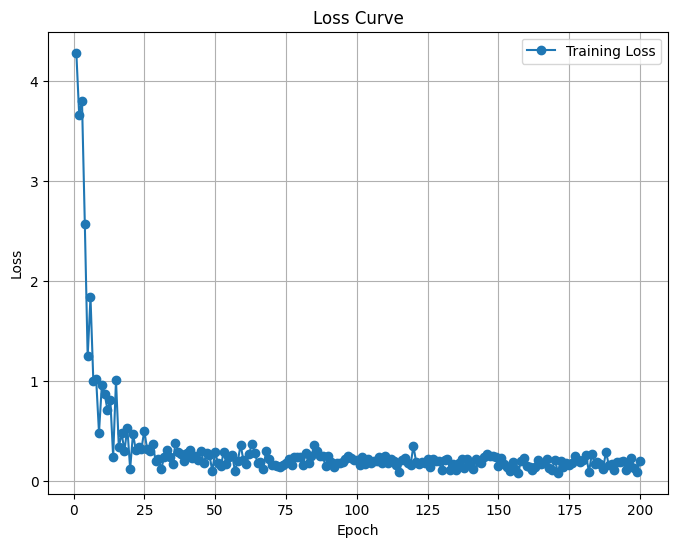

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [14]:
model.eval()
with torch.no_grad():
    predictions = model(X_train)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_train) ** 2))
print(f"Training Loss Scaling Unreversed: {rmse.item()}")

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions.numpy()))
y_train_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_train.numpy()))
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_train_reversed) ** 2))
print(f"Training Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 5.7322
Training Loss Scaling Unreversed: 0.1531585454940796
Training Loss Scaling Reversed: 1107.42431640625


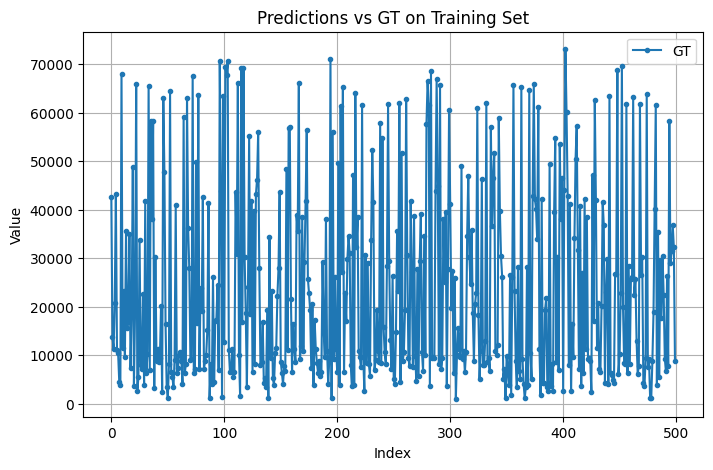

In [22]:

# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
#plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy()[:500], label='GT', marker='.')
plt.title('Predictions vs GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

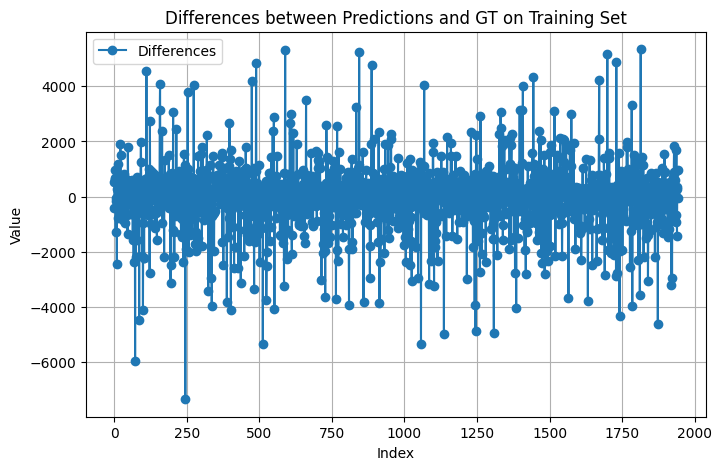

In [16]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Differences', marker='o')
plt.title('Differences between Predictions and GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_val) ** 2))
print(f"Training Loss Scaling Unreversed: {rmse.item()}")

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions.numpy()))
y_val_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_val.numpy()))
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_val_reversed) ** 2))
print(f"Training Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 0.4025
Training Loss Scaling Unreversed: 0.18582530319690704
Training Loss Scaling Reversed: 1343.6234130859375


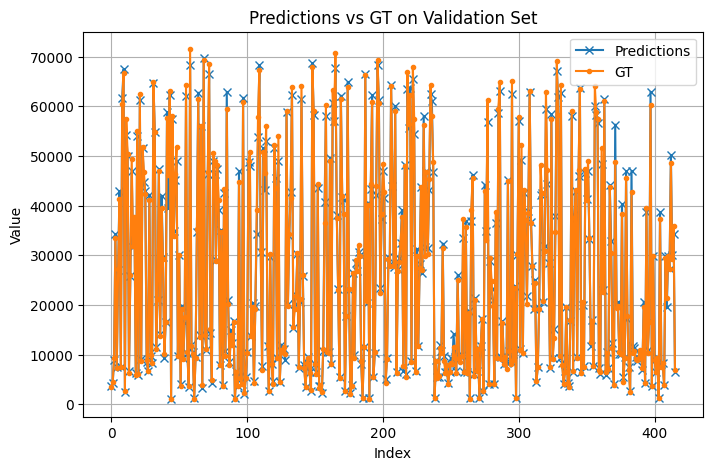

In [26]:
import matplotlib.pyplot as plt
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy(), label='GT', marker='.')
plt.title('Predictions vs GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

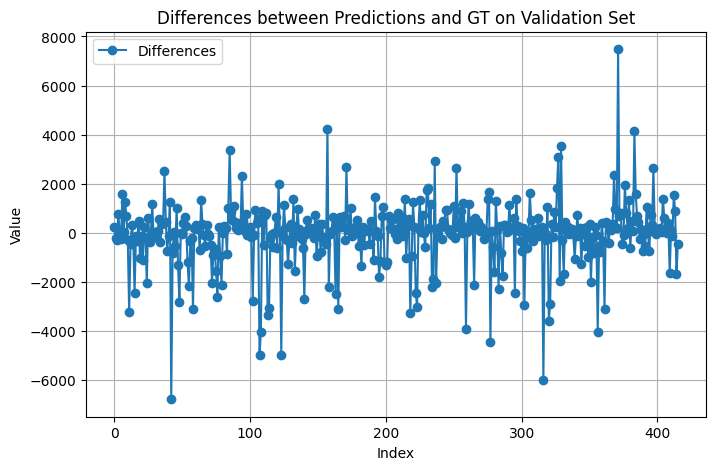

In [27]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Differences', marker='o')
plt.title('Differences between Predictions and GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()